In [453]:
from sklearn.compose import make_column_selector as selector
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

df = pd.read_csv("Month_Value_1.csv")
df["Period"] = pd.to_datetime(df.Period.apply(lambda x:x[3:]), format="%m.%Y")

In [454]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


In [455]:
series = df.set_index("Period")
series["TimeDummy"] = np.arange(series.shape[0])
series = series[series["Sales_quantity"].notnull()]
sales = series[["Sales_quantity", "TimeDummy"]]
sales["Lag"] = sales.Sales_quantity.shift(1)
sales = sales.dropna()

C:\Users\Lucas\AppData\Local\Temp\ipykernel_14404\4220258601.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales["Lag"] = sales.Sales_quantity.shift(1)


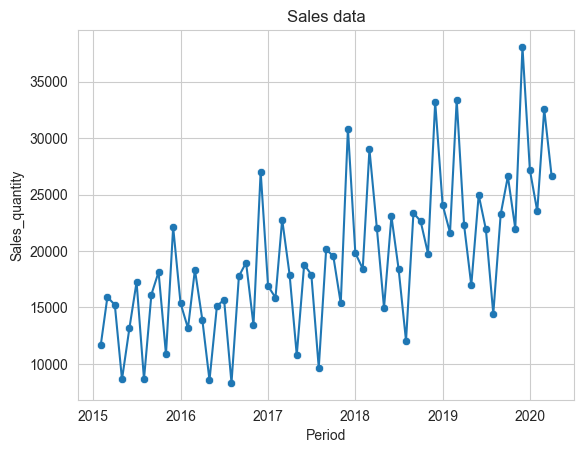

In [456]:
sns.scatterplot(sales.Sales_quantity).set_title("Sales data")
sns.lineplot(sales.Sales_quantity);

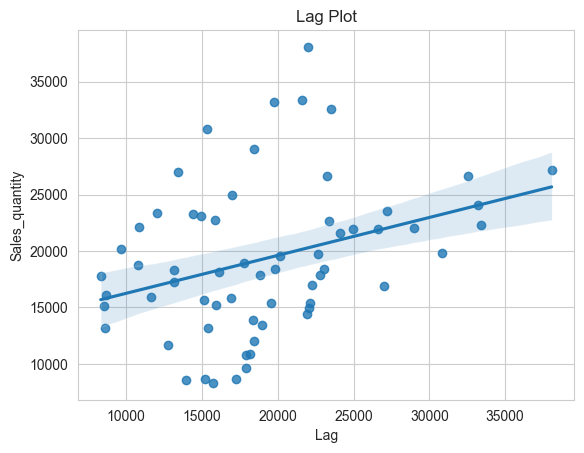

In [457]:
sns.regplot(sales, y="Sales_quantity", x="Lag").set_title("Lag Plot");

D:\DS_coisas\PythonVenv\lib\site-packages\statsmodels\tsa\deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


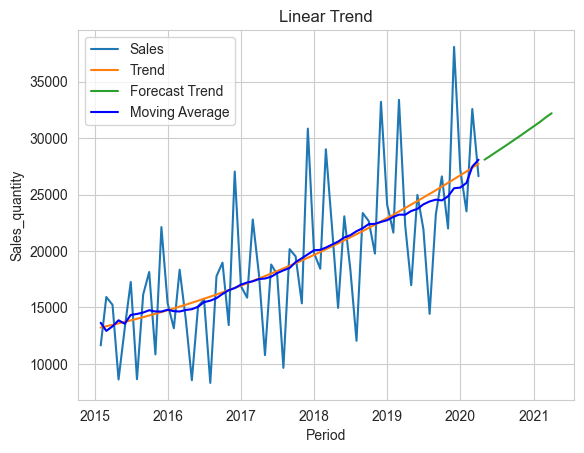

In [458]:
dp = DeterministicProcess(
    sales.index,
    constant=True,
    order=2,
    drop=True,
)

model = LinearRegression(fit_intercept=False)
model.fit(dp.in_sample(), sales.Sales_quantity)

trend_pred = pd.Series(model.predict(dp.in_sample()), index=sales.index)
fore_x = dp.out_of_sample(12)

start_date = np.datetime64(sales.index.max() + pd.DateOffset(months=1)).astype("datetime64[M]") 
end_date = np.datetime64(sales.index.max()) + pd.DateOffset(months=13)
end_date =np.datetime64(end_date).astype("datetime64[M]")
trend_fore = pd.Series(model.predict(fore_x), index=np.arange(start_date, end_date))

moving_average = sales.Sales_quantity.rolling(
    window=12,
    center=True,
    min_periods=3
).mean()

sns.lineplot(sales, x=sales.index, y=sales.Sales_quantity, label="Sales").set_title("Linear Trend")
sns.lineplot(trend_pred, label="Trend")
sns.lineplot(trend_fore,label="Forecast Trend")
sns.lineplot(moving_average, label="Moving Average",color="blue");

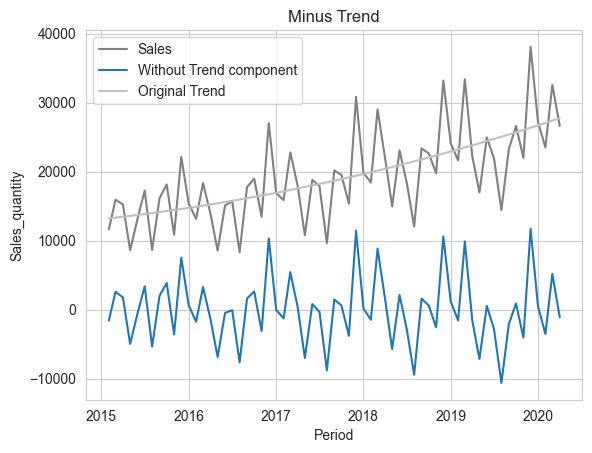

In [459]:
sns.lineplot(sales, x=sales.index, y=sales.Sales_quantity, label="Sales", color="gray").set_title("Minus Trend")
sns.lineplot(sales.Sales_quantity - trend_pred, label="Without Trend component")
sns.lineplot(trend_pred, label="Original Trend", color="silver");

In [460]:
print(f"p-value for original sales: {adfuller(sales.Sales_quantity)[1]:.3f}")
print(f"p-value for sales without trend: {adfuller(sales.Sales_quantity - trend_pred)[1]:.3f}")
# Almost 0.05. There's still some trend that the model didn't capture.
# For all purposes, let's reject the null hypothesis and consider the alternative.
# In fact, the variance changes a lot at the plot above.

p-value for original sales: 0.995
p-value for sales without trend: 0.946


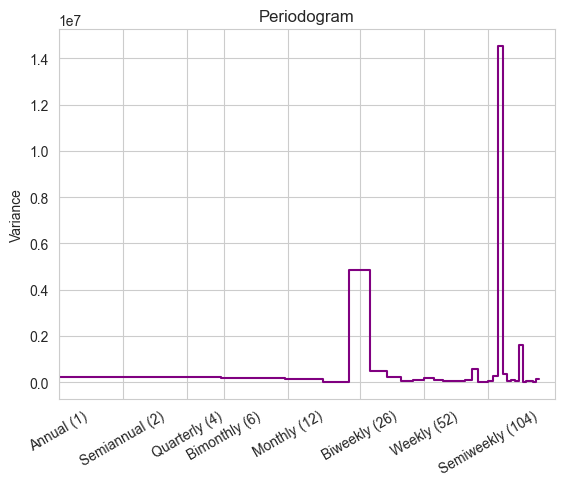

In [461]:
plot_periodogram(sales.Sales_quantity);

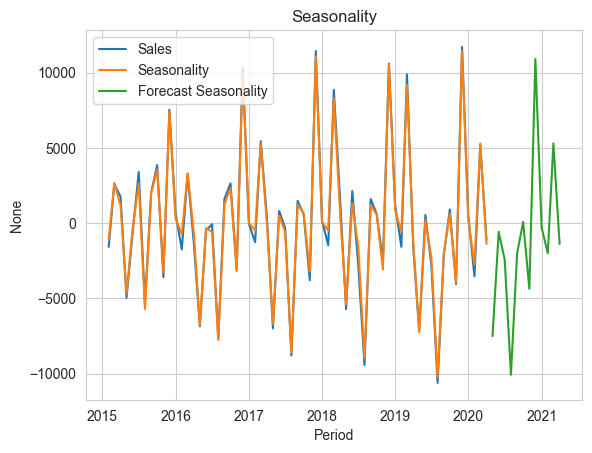

In [462]:
sales_season = sales.Sales_quantity - trend_pred

fourier = CalendarFourier("M", order=4)

dp = DeterministicProcess(
    sales_season.index.to_period(),
    constant=True,
    drop=True,
    seasonal=True,
    additional_terms=[fourier],
    order=2
)

model = GradientBoostingRegressor()
model.fit(dp.in_sample(), sales_season.values)

season_pred = pd.Series(model.predict(dp.in_sample()), index=sales_season.index)
fore_x = dp.out_of_sample(12)

start_date = np.datetime64(sales.index.max() + pd.DateOffset(months=1)).astype("datetime64[M]") 
end_date = np.datetime64(sales.index.max()) + pd.DateOffset(months=13)
end_date =np.datetime64(end_date).astype("datetime64[M]")
season_fore = pd.Series(model.predict(fore_x), index=np.arange(start_date, end_date))

sns.lineplot(sales, x=sales_season.index, y=sales_season, label="Sales").set_title("Seasonality")
sns.lineplot(season_pred, label="Seasonality")
sns.lineplot(season_fore,label="Forecast Seasonality");

Correlation of -0.23


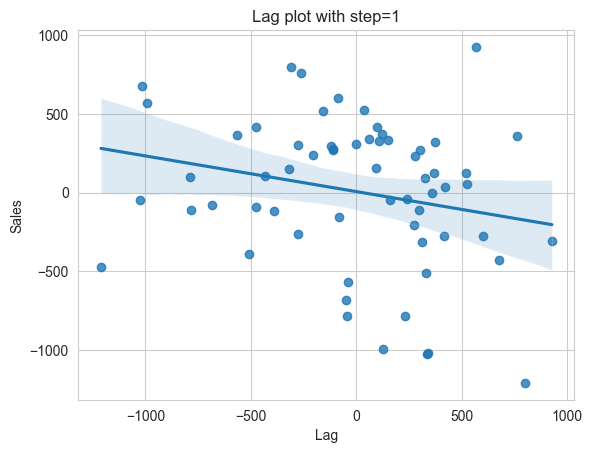

In [463]:
from statistics import correlation
sales_cycle = pd.DataFrame(sales_season - season_pred)
sales_cycle[1] = sales_cycle.shift(1)
sales_cycle = sales_cycle.rename(columns={0:"Sales", 1:"Lag"}).dropna()

sns.regplot(sales_cycle, x="Lag", y="Sales").set_title("Lag plot with step=1")
print(f"Correlation of {correlation(sales_cycle.Lag, sales_cycle.Sales):.2f}")

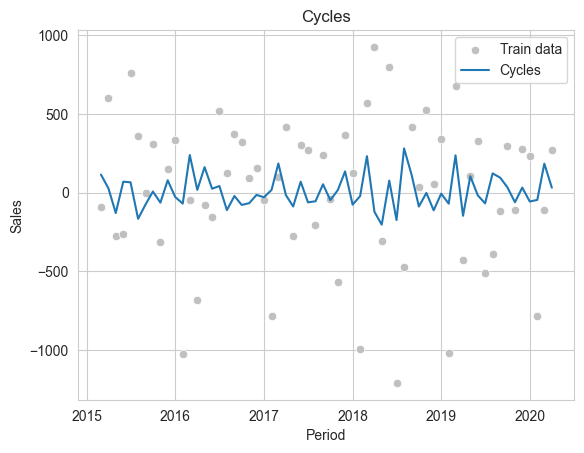

In [464]:
model = LinearRegression(fit_intercept=True)

X_train = np.reshape(sales_cycle.Lag, (-1,1))
y_train = sales_cycle.Sales

model.fit(X_train,y_train)
cycle_pred = model.predict(X_train)

sns.scatterplot(sales_cycle.Sales, label="Train data", color="silver").set_title("Cycles")
sns.lineplot(x=y_train.index, y=cycle_pred, label="Cycles");

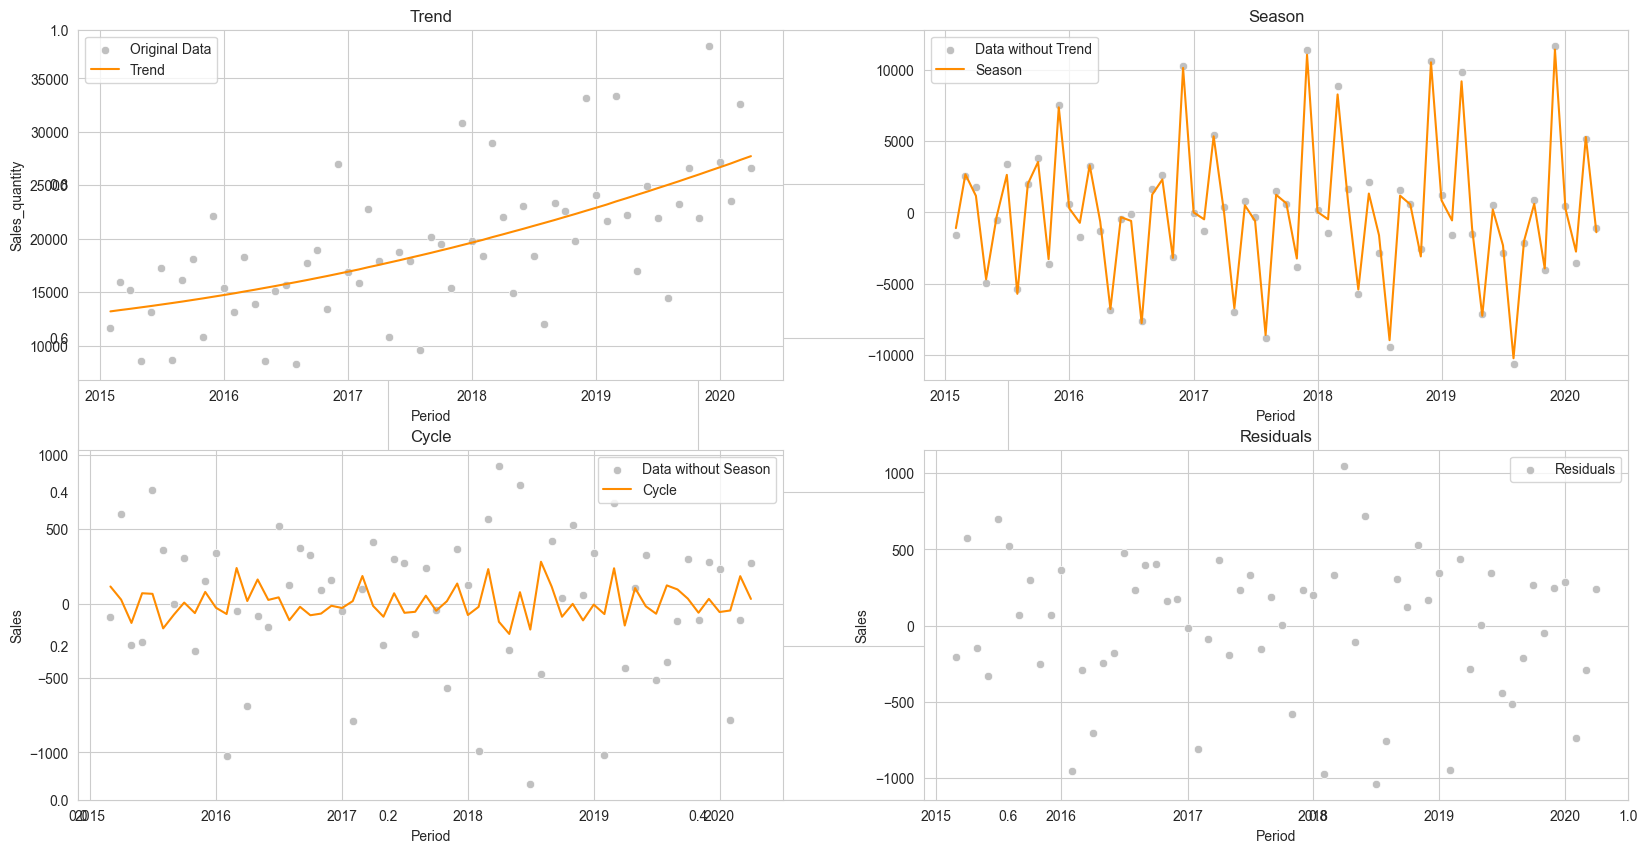

In [465]:
residuals = sales_cycle.Sales - cycle_pred

plt.subplots(figsize=(20,10), sharex=True)

plt.subplot(221)
sns.scatterplot(sales.Sales_quantity, label="Original Data", color="silver").set_title("Trend")
sns.lineplot(trend_pred, label="Trend", color="darkorange")

plt.subplot(222)
sns.scatterplot(sales_season, label="Data without Trend", color="silver").set_title("Season")
sns.lineplot(season_pred, label="Season", color="darkorange")

plt.subplot(223)
sns.scatterplot(sales_cycle.Sales, label="Data without Season", color="silver").set_title("Cycle")
sns.lineplot(y=cycle_pred, x=sales_cycle.index, label="Cycle", color="darkorange")

plt.subplot(224)
sns.scatterplot(residuals, label="Residuals", color="silver").set_title("Residuals")
plt.plot();

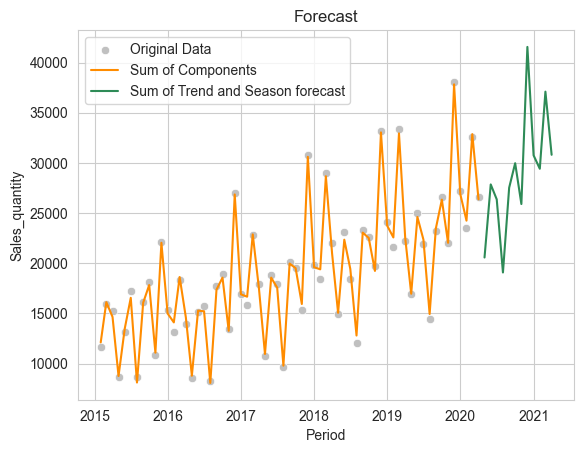

In [466]:
sum_of_components = trend_pred + season_pred + np.insert(cycle_pred, 0, 0)
final_forecast = trend_fore + season_fore

sns.scatterplot(sales.Sales_quantity, color="silver", label="Original Data").set_title("Forecast")
sns.lineplot(y=sum_of_components, x=sales.index, color="darkorange", label="Sum of Components")
sns.lineplot(final_forecast, label="Sum of Trend and Season forecast", color="seagreen");

### Aggregating the boosted model
Linear models excels at extrapolating (forecasts), while tree based and other ensembles do not.
Because of that, we can fit the Trend component into a Linear Regression and the rest into an ensemble model.
For our case, we'll use a Linear Regression and Gradient Boosting (tree-based).

In [572]:
class FinalModel:
    def __init__(self, first_model,second_model):
        self.first_model = first_model
        self.second_model = second_model
        self.first_dp = None
        self.second_dp = None
        self.last_known_date = None
        self.trend = None
        
    def fit(self, data, target, return_fitting=False):
        self.last_known_date = data.max()  # For later uses in prediction
        self.first_dp = DeterministicProcess(
            data,
            constant=True,
            order=4,
            drop=True,
            )
        
        self.first_model.fit(self.first_dp.in_sample(), target)
        self.trend = self.first_model.predict(self.first_dp.in_sample())
        
        residual_pred = target - self.first_model.predict(self.first_dp.in_sample())
        residual_pred = pd.Series(residual_pred, index=data)
        
        fourier = CalendarFourier("M", order=4)

        self.second_dp = DeterministicProcess(
            data.to_period("M"),
            constant=True,
            drop=True,
            seasonal=True,
            additional_terms=[fourier],
            order=4
            )   
        
        self.second_model.fit(self.second_dp.in_sample(), residual_pred)
        
        if return_fitting: 
            return self.predict_internal(data)
    
    def predict_internal(self, data): 
        prediction = pd.Series(
            data=self.first_model.predict(self.first_dp.in_sample()) + self.second_model.predict(self.second_dp.in_sample()),
            index= data)
        
        return prediction
    
    def predict(self, steps=None, date_range=None):
        if not hasattr(date_range, "__len__"):
            first_date = np.datetime64(self.last_known_date + pd.DateOffset(months=1)).astype("datetime64[M]") 
            last_date = np.datetime64(self.last_known_date) + pd.DateOffset(months=steps + 1)
            last_date =np.datetime64(last_date).astype("datetime64[M]")
            date_range = np.arange(first_date, last_date)
        
        if not steps:
            timedelta = date_range.max() - date_range.min()
            steps = (timedelta.days // 30) + 1
            
        first_prediction = self.first_model.predict(self.first_dp.out_of_sample(steps))
        second_prediction = self.second_model.predict(self.second_dp.out_of_sample(steps))
    
        forecast = pd.Series(
            data=first_prediction + second_prediction,
            index=date_range)
        
        return forecast
        
    def score(self, prediction, target, MAE=None, MSE=None):
        if MAE == MSE:
            raise Exception("Choose only one error metric.")
        
        errors = target - np.reshape(prediction, (-1, 1))
        
        if MAE:
            errors = abs(errors)
            
        if MSE:
            errors = errors ** 2
        
        sum_errors = errors.sum()
        mean_squared_error = sum_errors / len(target)
        
        return float(mean_squared_error.iloc[0])


In [548]:
model = FinalModel(LinearRegression(fit_intercept=False), GradientBoostingRegressor())
model.fit(sales.index, sales.Sales_quantity)

D:\DS_coisas\PythonVenv\lib\site-packages\statsmodels\tsa\deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


<Axes: xlabel='Period', ylabel='Sales_quantity'>

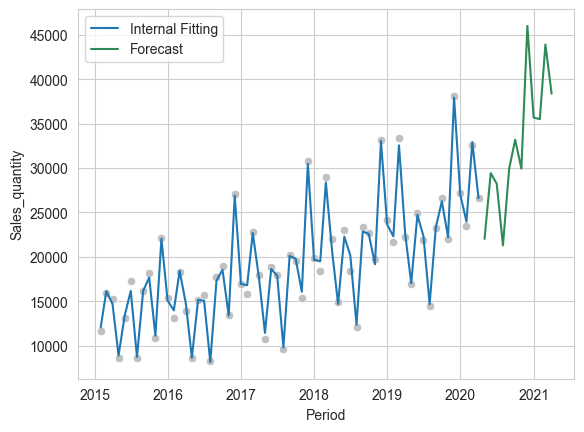

In [549]:
sns.scatterplot(sales.Sales_quantity, color="silver")
sns.lineplot(model.predict_internal(sales.index), label="Internal Fitting")
sns.lineplot(model.predict(12), label="Forecast", color="seagreen")

D:\DS_coisas\PythonVenv\lib\site-packages\statsmodels\tsa\deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


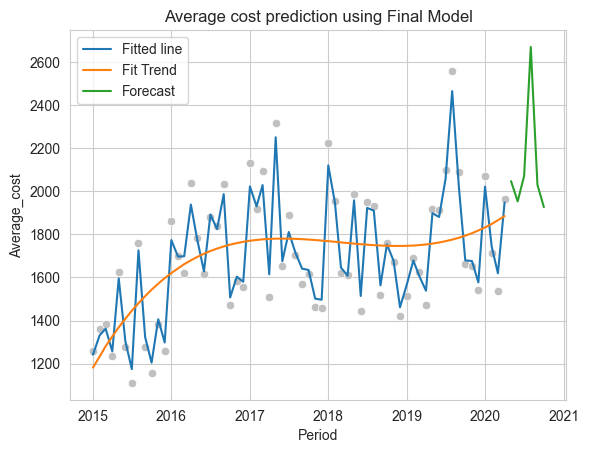

In [550]:
model = FinalModel(LinearRegression(fit_intercept=False), GradientBoostingRegressor())
model.second_model.set_params(**{"max_depth":10, "n_estimators":20})
data = df[["Period", "Average_cost"]].set_index("Period").dropna()
trained_data = model.fit(data.index, data.Average_cost, return_fitting=True)
forecast = model.predict(6)

sns.scatterplot(x=data.index, y=data.Average_cost, color="silver").set_title("Average cost prediction using Final Model")
sns.lineplot(trained_data, label="Fitted line")
sns.lineplot(y=model.trend, x=data.index, label="Fit Trend")
sns.lineplot(forecast, label="Forecast");

D:\DS_coisas\PythonVenv\lib\site-packages\statsmodels\tsa\deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


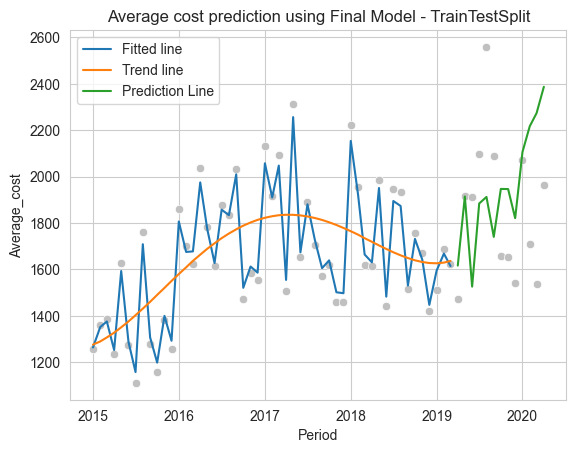

In [584]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

data = df[["Period", "Average_cost"]].set_index("Period").dropna()
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

model = FinalModel(LinearRegression(), GradientBoostingRegressor())
model.second_model.set_params(**{"max_depth":10, "n_estimators":20})
trained_data = model.fit(train_data.index, train_data.Average_cost, return_fitting=True)


sns.scatterplot(x=data.index, y=data.Average_cost, color="silver").set_title("Average cost prediction using Final Model - TrainTestSplit")
sns.lineplot(trained_data, label="Fitted line")
sns.lineplot(x=trained_data.index, y=model.trend, label="Trend line")
sns.lineplot(model.predict(date_range=test_data.index), label="Prediction Line");